# Temporal Response Functions

In [1]:
import mne
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore

import seaborn as sns
from mtrf.model import TRF
from mtrf.stats import crossval, pearsonr, neg_mse

import pymatreader
import random

## Example Regression

The most popular implementation of the TRF approach uses so-called Ridge Regression to map between stimulus features and neural responses. In order to better grasp what it does to the coefficients, we creare a small toy example, in which y (100 values; e.g., height of person) is predicted by X (50 features; e.g., sex, age, dietary habits etc. of a person).

We will create 2 versions of X: one in which each feature is independent of all others, and another in which there is some dependency between the features (i.e., collinearity).

In [2]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error
# Import necessary modules

# Generate some random data
np.random.seed(42)
X = np.random.rand(100, 50)
y = np.random.rand(100)

X_collinear = np.random.rand(100, 50)

# Create the remaining 5 columns as linear combinations of the existing columns
for i in range(25):
    new_col = X[:, i] * 2 + np.random.rand(100) * 0.01
    X_collinear = np.column_stack((X_collinear, new_col))

We now use regression for the prediction, training on the first 80 observations and testing the prediction on the held-out 20 observations. In one version we use standard Linear Regression. In another version we use Ridge Regression.

/var/folders/hq/25wkh5ks4x3bl8rfsmsnt_vw2w8qk_/T/ipykernel_55269/1968733645.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--bo" (-> color='b'). The keyword argument will take precedence.
  ax1.plot(np.arange(1, len(ridge.coef_)+1), ridge.coef_, '--bo', color = 'red')
/var/folders/hq/25wkh5ks4x3bl8rfsmsnt_vw2w8qk_/T/ipykernel_55269/1968733645.py:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--bo" (-> color='b'). The keyword argument will take precedence.
  ax2.plot(np.arange(1, len(ridge_collinear.coef_)+1), ridge_collinear.coef_, '--bo', color = 'red')


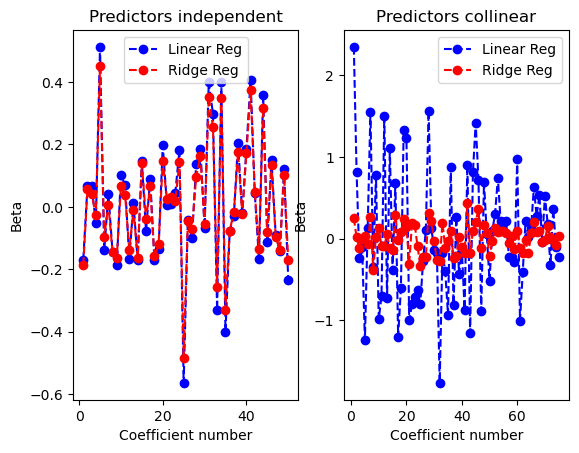

In [3]:
# Split the data into training (80) and testing sets (20)
X_train, X_test = X[:80], X[80:]
X_collinear_train, X_collinear_test = X_collinear[:80], X_collinear[80:]
y_train, y_test = y[:80], y[80:]

# Fit a linear regression model
lr = LinearRegression()
lr_collinear = LinearRegression()
lr.fit(X_train, y_train)
lr_collinear.fit(X_collinear_train, y_train)

# Fit a ridge regression model
ridge = Ridge(alpha=0.1)
ridge_collinear = Ridge(alpha=0.1)
ridge.fit(X_train, y_train)
ridge_collinear.fit(X_collinear_train, y_train)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(np.arange(1, len(lr.coef_)+1), lr.coef_, '--bo')
ax1.plot(np.arange(1, len(ridge.coef_)+1), ridge.coef_, '--bo', color = 'red')
ax1.set_title("Predictors independent")
ax1.set_xlabel("Coefficient number")
ax1.set_ylabel("Beta")
ax1.legend(["Linear Reg", "Ridge Reg"])

ax2.plot(np.arange(1, len(lr_collinear.coef_)+1), lr_collinear.coef_, '--bo')
ax2.plot(np.arange(1, len(ridge_collinear.coef_)+1), ridge_collinear.coef_, '--bo', color = 'red')
ax2.set_title("Predictors collinear")
ax2.set_xlabel("Coefficient number")
ax2.set_ylabel("Beta")
ax2.legend(["Linear Reg", "Ridge Reg"])

Plotting the coefficients, what do you observe?

Looking at the prediction accuracies, what do you observe?

In [4]:
# Compare the mean squared error of the two models on the test set
print("Predictors independent:")
print("Linear Regression MSE:", mean_squared_error(y_test, lr.predict(X_test)))
print("Ridge Regression MSE:", mean_squared_error(y_test, ridge.predict(X_test)))

print("Predictors collinear:")
print("Linear Regression MSE:", mean_squared_error(y_test, lr_collinear.predict(X_collinear_test)))
print("Ridge Regression MSE:", mean_squared_error(y_test, ridge_collinear.predict(X_collinear_test)))

Predictors independent:
Linear Regression MSE: 0.4038396338415672
Ridge Regression MSE: 0.33116653323991196
Predictors collinear:
Linear Regression MSE: 4.496803182826639
Ridge Regression MSE: 0.2427591647894491


## Example Dataset

We will use a dataset provided by Chandra Haider, from [this publication](https://www.sciencedirect.com/science/article/pii/S1053811922001732?via%3Dihub).

![Stimuli Chandra](https://ars.els-cdn.com/content/image/1-s2.0-S1053811922001732-gr1.jpg)

We will use the fantastic [pymatreader](https://pypi.org/project/pymatreader/) developed by Thomas Hartmann to get data preprocessed in matlab.

In [5]:
datapath = "/Users/b1019548/Library/CloudStorage/OneDrive-UniversitätSalzburg/Teaching/Master_VO_MethodsCogNeuro//Lecture6_TRFs/data/19950913GBWL.mat"

info = mne.io.read_info("sample-info.fif", verbose = True)
info = mne.Info(info, sfreq=100)

data = pymatreader.read_mat(datapath)
#find out what is inside:
#data['corona_preprocData'].keys()

fs = data['corona_preprocData']['fsample'] #sampling rate ... strongly downsampled to 50 Hz
megdata = data['corona_preprocData']['trial'] #40 trials overall

Durations are not equal. Let's check.

Text(0.5, 0, 'Trial Number')

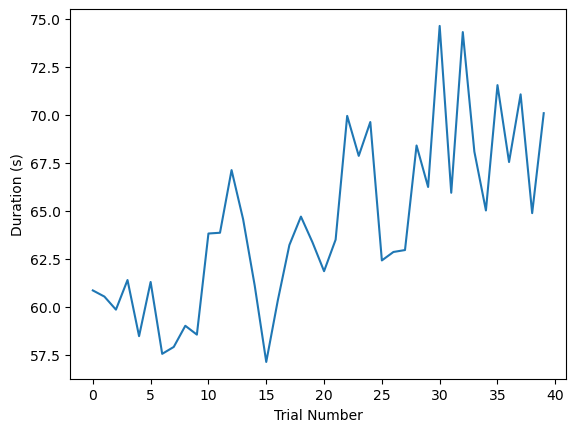

In [6]:
num_cols = []
for trial in megdata:
    num_cols.append(trial.shape[1])
    
plt.plot(range(0, len(num_cols)), np.divide(num_cols, fs))
plt.ylabel("Duration (s)")
plt.xlabel("Trial Number")


For mTRF let's create a response and stimulus list. We need to transponse as the mtrf functions wants data as samples x channels / features 

In [7]:
# get the neural data
response = []
stimulus = []

indices = np.where(data['corona_preprocData']['trialinfo'][:,1] == 0)
indices_sel = random.sample(range(0, len(indices[0])), 25)

# we will only pick trials without distractor and pick 5 trials (i.e. ~5 mins data)
for ii in indices_sel:
    trial = megdata[indices[0][ii]]
    trial = zscore(trial, axis=1)
    response.append(trial[:306, :].transpose())
    stimulus.append(trial[[307], :].transpose())

Ridge regression requires you to fiind optimal regularization parameter.

Cross-validating[##################################################] 25/25....] 0/25

Cross-validating[##################################################] 25/25....] 1/25

Cross-validating[##################################################] 25/25....] 2/25

Cross-validating[##################################################] 25/25....] 3/25

Cross-validating[##################################################] 25/25....] 4/25

Cross-validating[##################################################] 25/25....] 5/25

Cross-validating[##################################################] 25/25....] 6/25

Cross-validating[##################################################] 25/25....] 7/25

Cross-validating[##################################################] 25/25....] 8/25

Cross-validating[##################################################] 25/25....] 9/25

Cross-validating[##################################################] 25/25....] 10/25

Cross-validating[####################################

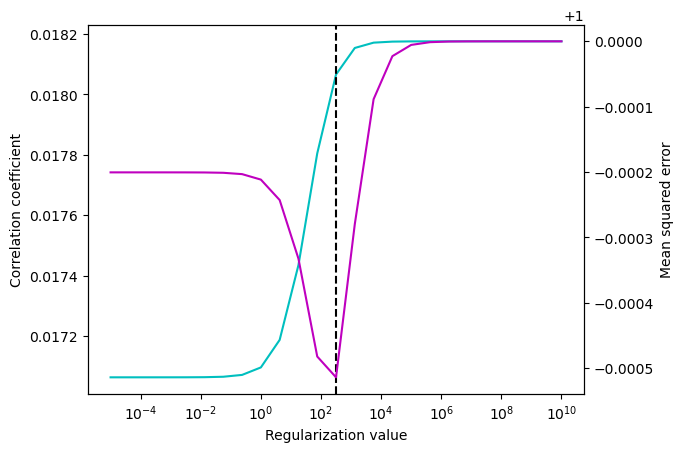

In [8]:
tmin, tmax = -.2, 0.6  # range of time lags
regularization = np.logspace(-5, 10, 25)

trf = TRF(direction=1, metric=neg_mse)  # use negative meas squared error
# multiply by -1 to get the mean squared error
mse = trf.train(stimulus, response, fs, tmin, tmax, regularization) * -1

trf = TRF(direction=1, metric=pearsonr)  # use pearsons correlation
r = trf.train(stimulus, response, fs, tmin, tmax, regularization)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.semilogx(regularization, r, color='c')
ax2.semilogx(regularization, mse, color='m')
ax1.set(xlabel='Regularization value', ylabel='Correlation coefficient')
ax2.set(ylabel='Mean squared error')
ax1.axvline(regularization[np.argmin(mse)], linestyle='--', color='k')
plt.show()

We will pick, the “optimal“ regularization value to get the TRFs.

In [9]:
fwd_trf = TRF(direction=1)
tmin, tmax = -0.2, 0.6  # range of time lag
regval = regularization[np.argmin(mse)] # regularization parameter lambda
fwd_trf.train(stimulus, response, fs, tmin, tmax, regval)

Do leave-one-out crossvalidation and get average prediction accuracy.

In [10]:
r_fwd = crossval(fwd_trf, stimulus, response, fs, tmin, tmax, regval, average = False)
print(f"mean correlation between actual and predicted response: {r_fwd.mean().round(3)}")

Cross-validating[##################################################] 25/25

mean correlation between actual and predicted response: 0.018


We can also check the prediction accuracy for each channel.

In [11]:
mag_indices = mne.pick_types(info, meg="mag")
infoMAG = mne.pick_info(info, mag_indices)

grad_indices = mne.pick_types(info, meg="grad")
infoGRAD = mne.pick_info(info, grad_indices)

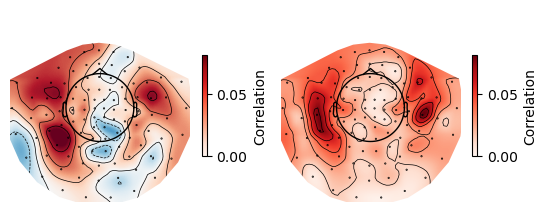

In [12]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
img, _ = mne.viz.plot_topomap(r_fwd[mag_indices-mag_indices[0]], infoMAG, axes = ax1, show=False)
img, _ = mne.viz.plot_topomap(r_fwd[grad_indices-grad_indices[0]], infoGRAD, axes = ax2, show=False)

cbar = plt.colorbar(
    ax=ax1, shrink=0.25, orientation='vertical', mappable=img,
)
cbar.set_label('Correlation')

cbar = plt.colorbar(
    ax=ax2, shrink=0.25, orientation='vertical', mappable=img,
)
cbar.set_label('Correlation')

No projector specified for this dataset. Please consider the method self.add_proj.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


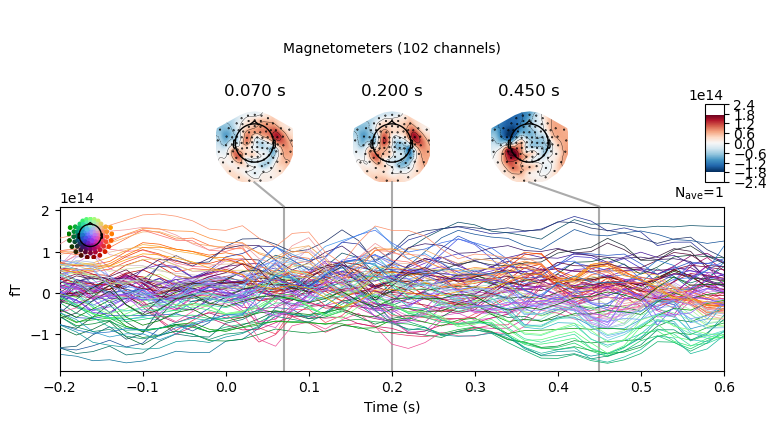

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


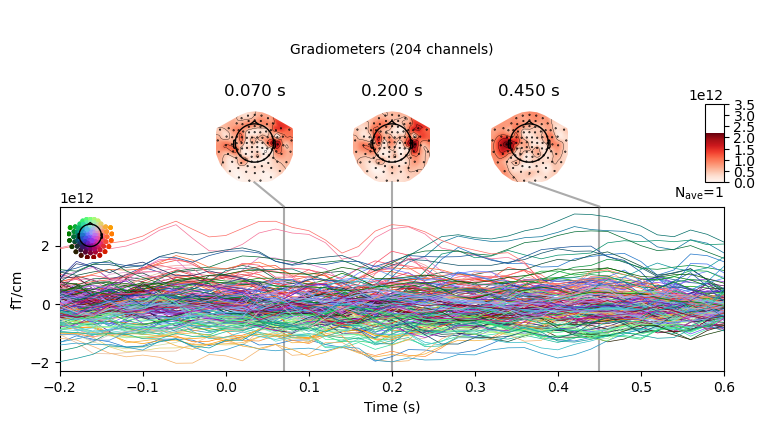

[<Figure size 800x420 with 7 Axes>, <Figure size 800x420 with 7 Axes>]

In [13]:
info = mne.io.read_info("sample-info.fif", verbose = True)
info = mne.Info(info, sfreq=fs)

meg_indices = mne.pick_types(info, meg=True)
reduced_info = mne.pick_info(info, meg_indices)

evokeds = fwd_trf.to_mne_evoked(info = reduced_info)
evokeds[0].plot_joint([0.07, 0.2, 0.45])